In [1]:
# import numerical libraries
import numpy as np
import scipy.interpolate
import os

# the data is stored in a HDF5 file
# so import the tools to load HDF5 files
import h5py

# import plotting tools and set up
# inline figures for the notebook
import matplotlib.pyplot as plt

%matplotlib inline

# the description of the maze is encoded in YAML
# so let's import tools to parse YAML
import yaml

# Fklab-python-core tool 
#-----------------------

# importing the shapes module is needed to extend the YAML parser
# so that it recognizes YAML representations of shapes
import fklab.geometry.shapes

# import utilities to work with time segments
import fklab.segments

# Py-compressed-kde package
# -------------------------

# finally, import the decoding tools
import compressed_kde
from compressed_kde import decode



In [2]:
import mat73
import scipy.io as spio

## load data

In [3]:
RESULTS_PATH = "/home/katharina/Documents/Studium/MIT/project/data/circular_unclustered/"
sp = mat73.loadmat(RESULTS_PATH+'sp.mat')
stimulus = mat73.loadmat(RESULTS_PATH+'stim.mat')
vel = mat73.loadmat(RESULTS_PATH+'vel.mat')
neuro = mat73.loadmat(RESULTS_PATH+'ix4circTrack.mat')
sp = mat73.loadmat(RESULTS_PATH+'spikesCircTrack.mat')

### stimulus data

In [5]:
stimulus.keys()

dict_keys(['stimulus', 'stimulus_grid', 'stimulus_kernel', 'stimulus_variable_type'])

In [6]:
stimulus['stimulus']['linearpos'].keys()

dict_keys(['linearpos', 'rundir', 'timestamp'])

In [7]:
vel['vel']['data']

array([0.        ,        nan,        nan, ..., 0.73346256, 0.        ,
       0.        ])

In [4]:
speed = abs(vel['vel']['data'])
# speed_threshold 15 cm/s
runseg = vel['vel']['runseg']

In [67]:
stimulus['stimulus']['timestamp'][160948]

6388.6739

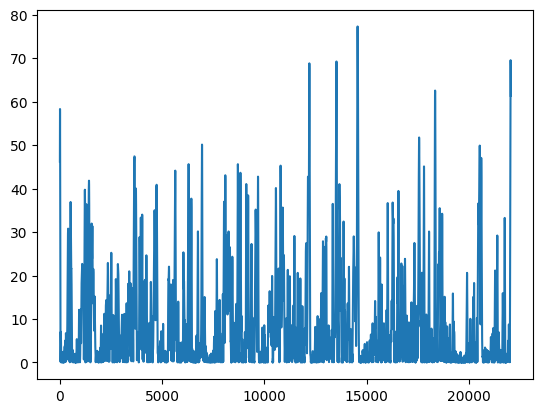

In [68]:
# time of run:
# 5650.8  6388.7s
# 138835 - 160951
plt.plot(abs(vel['vel']['data'][138835:160951]))

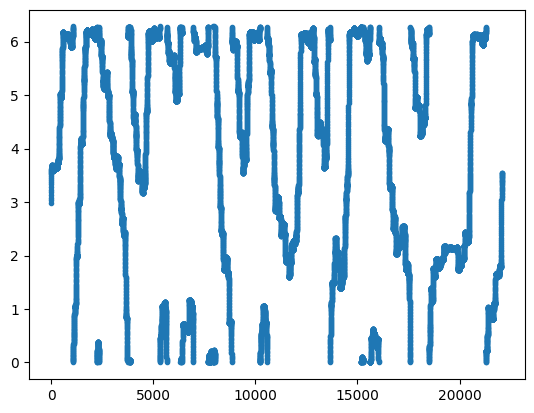

In [69]:
plt.plot(stimulus['stimulus']['linearpos'][138835:160951], '.')

In [10]:
stimulus['stimulus_kernel']  # 100, 0.5

['vonmises', 'kronecker']

In [11]:
# conversion circular to cm: 61

### spike data

In [12]:
sp.keys()

dict_keys(['response_bandwidth', 'response_kernel', 'response_selection', 'response_variable_type', 'sp', 'spResponse', 'spStimulus', 'spTimestapm'])

In [13]:
# selection amp_threshold 75e-6mV (100e-6mV)

In [302]:
sp['response_bandwidth'] # kernel epanechnikov

array(4.e-05)

## building decoder

In [4]:
# amp_threshold = (70.0) # uV, only use spikes with maximum amplitude larger than this threshold
# set kernel bandwidths and compression for encoding
pos_bw = np.pi/36  # cm, default spatial kernel bandwidth
#amp_bw = 30.0  # uV, default spike amplitude kernel bandwidth
amp_bw = 0.00004  # sp['response_bandwidth']
compression = 0.5 # kernel density compression Mahalanobis distance threshold

# set evaluation grid resolution
#fine_grid_resolution = 2.0
# cm, spatial grid used to build squared distance matrix
#grid_resolution = 4.0
# cm, spatial grid for decoding (should be multiple of fine grid)

# set behavior options
stim_sampling_frequency = 30.0  # Hz, sampling frequency of position tracking
speed_threshold = 15.0  # cm/s, only use data when animal runs faster than speed threshold for building encoding model

# set decoding options
decode_bin = 0.2  # seconds, bin size for run decoding

In [104]:
#ix = [(resp[:,4]> 0.0003) & (np.any(resp[:,:4]>75e-6, axis=1)) for resp in sp['spResponse']]

In [5]:
#with np.errstate(invalid="ignore"):  # get rid of annoying warning about NaNs
#    selection = [np.max(tt_data[tt][1:, :], axis=0) > amp_threshold for tt in tt_selection]

# tt_time = sp['spTimestapm']
tt_time = [time[i] for time, i in zip(sp['sp']['timestamp'], sp['sp']['ix'])]
# tt_amp = [x[:,:-1] for x in sp['spResponse']]   # remove spike width
tt_amp = [resp[i][:,:-1] for resp, i in zip(sp['sp']['response'], sp['sp']['ix'])]
# tt_pos = sp['spStimulus']
tt_pos_rd = [np.vstack((p,r)).T for p, r in zip(sp['sp']['stimuluslinpos'], sp['sp']['stimulusrundir'])]
tt_pos = [pos[i] for pos, i in zip(tt_pos_rd, sp['sp']['ix'])]


In [6]:
rd = stimulus['stimulus']['rundir']
rd[rd==0] = 1
rd[rd==-1] = 0

In [7]:
pos = np.concatenate([stimulus['stimulus']['linearpos'][:, None], rd[:, None]], axis=1)

In [8]:
speed = abs(vel['vel']['data'])

In [9]:
# determine run epochs
with np.errstate(invalid="ignore"):  # get rid of annoying warning about NaNs
    run_epochs = fklab.segments.Segment.fromlogical(
        abs(speed[:]) > speed_threshold, stimulus['stimulus']['timestamp'][:]
    )

In [10]:
# construct multi-dimensional euclidean space for spike amplitudes with default kernel bandwidth
spike_space = compressed_kde.EuclideanSpace(
    ["amp{0}".format(x) for x in range(4)], bandwidth=[amp_bw,] * 4
)

In [11]:
linear_pos_interpolator = scipy.interpolate.interp1d(
    stimulus['stimulus']['timestamp'], stimulus['stimulus']['linearpos'], kind="nearest", bounds_error=False
)

In [12]:
linear_rd_interpolator = scipy.interpolate.interp1d(
    stimulus['stimulus']['timestamp'], stimulus['stimulus']['rundir'], kind="nearest", bounds_error=False
)

In [35]:
circular_space = compressed_kde.CircularSpace(
    'x',        # the name of the space
    kappa=5,  # concentration for von Mises kernel
    mu=0        # center for von Mises kernel
)
circular_grid = circular_space.grid(
    n=77,     # number of grid points around the circle
    offset=0  # rotational offset
)

In [14]:
x = np.linspace(0, 6.3, 30)

In [15]:
lin_space = compressed_kde.EuclideanSpace(
    ['x'],      # list of labels for all dimensions
    kernel=compressed_kde.GaussianKernel(),  # desired kernel
    bandwidth=[pos_bw]     # list of bandwidths for all dimensions
)
lin_grid = lin_space.grid(
    [x],  # list of coordinate vectors for all dimensions
)

In [16]:
direction_space = compressed_kde.CategoricalSpace(
    'rd',      # the name of the space
    ['0', '1'] # a list of category labels
    )
direction_grid = direction_space.grid()

In [17]:
direction_grid.points()

array([[0.],
       [1.]])

In [36]:
space = compressed_kde.MultiSpace([circular_space, direction_space])
grid = space.grid([circular_grid, direction_grid])

In [37]:
def decoder_build_factory(**kwargs):

    kwd = {
        "stimulus_space",
        "grid",
        "stimulus_duration",
        "compression",
        "stimulus",
        "stimulus_time",
        "event_time",
        "event_stimulus",
        "event_data",
        "event_space",
    }

    if not kwd.issubset(set(kwargs.keys())):
        raise ValueError("We are missing some keyword arguments")

    def fcn(epochs):

        # first create a Stimulus object that represents the stimulus probability density
        stim = decode.Stimulus(
            kwargs["stimulus_space"],
            kwargs["grid"],
            kwargs["stimulus_duration"],
            kwargs["compression"],
        )
        stim.add_stimuli(
            kwargs["stimulus"][epochs.contains(kwargs["stimulus_time"])[0]]
        )

        # then build the likelihoods for each of the sources (tetrodes)
        likelihoods = []
        for event_time, event_stimulus, event_data in zip(
            kwargs["event_time"], kwargs["event_stimulus"], kwargs["event_data"]
        ):
            selection = epochs.contains(event_time)[
                0
            ]  # select events within training epochs
            L = decode.PoissonLikelihood(kwargs["event_space"], stim)
            L.add_events(
                np.concatenate(
                    (event_data[selection], event_stimulus[selection]), axis=1
                )
            )
            likelihoods.append(L)

        # build decoder from likelihoods
        decoder = decode.Decoder(likelihoods, [])

        return decoder, likelihoods

    return fcn

In [38]:
data = dict(stimulus_space = space,
            grid = grid,
            stimulus_duration = 1./stim_sampling_frequency,
            compression = compression,
            stimulus = pos,
            stimulus_time = stimulus['stimulus']['timestamp'],
            event_time = tt_time,
            event_data = tt_amp,
            event_stimulus = tt_pos,
            event_space = spike_space,
           )

build_decoder = decoder_build_factory(**data)

In [39]:
def data_build_factory(**kwargs):

    kwd = {"decode_bin", "event_time", "event_data"}

    if not kwd.issubset(set(kwargs.keys())):
        raise ValueError("We are missing some keyword arguments")

    def fcn(epochs):

        # split epochs into smaller bins for decoding
        decode_segments = epochs.split(size=kwargs["decode_bin"])
        bins = [
            decode_segments.contains(x, expand=True)[2] for x in kwargs["event_time"]
        ]

        # extract event data for each decoding bin
        data = [
            [
                np.zeros((0, x.shape[1]))
                if len(b[s]) == 1 and b[s][0] == -1
                else x[b[s], :]
                for x, b in zip(kwargs["event_data"], bins)
            ]
            for s in range(len(decode_segments))
        ]

        return decode_segments, data

    return fcn

In [40]:
data = dict(decode_bin=decode_bin, event_time=tt_time, event_data=tt_amp)

build_data = data_build_factory(**data)

### perform cross-validation

In [41]:
np.linspace(5650.8 ,6388.7, 6)

array([5650.8 , 5798.38, 5945.96, 6093.54, 6241.12, 6388.7 ])

In [42]:
segemnts = [[5650.8, 5798.38], [5798.38, 5945.96], [5945.96, 6093.54], [6093.54, 6241.12],[6241.12, 6388.7]]

In [43]:
trials = fklab.segments.Segment(
    [[5650.8, 5798.38], [5798.38, 5945.96], [5945.96, 6093.54], [6093.54, 6241.12],[6241.12, 6388.7]]
)
ntrials = len(trials)

In [45]:
# create lists for collecting real position, estimates and errors
posteriors_c = []

pos_reals_c = []
pos_estimates_c = []
pos_errors_c = []

dir_reals_c = []
dir_estimates_c = []
dir_errors_c = []

# perform ntrial-fold cross validation
# i.e. each trial will be used for test data once and
# the others are used for training data

for test_trial in range(ntrials):
    print(test_trial)

    # set training epochs to all trials except the test trial
    training_epochs = run_epochs.intersection(
        trials[[trial for trial in range(ntrials) if trial != test_trial]]
    )

    # construct decoder for current training epochs
    decoder, likelihoods = build_decoder(training_epochs)

    # test data during run maze arm runs for test trial only
    test_epochs = run_epochs.intersection(trials[test_trial])

    # extract event data for each time bin
    decode_segments, data = build_data(test_epochs)

    # perform decoding and concatenate posteriors
    posterior = [decoder.decode(x, decode_bin, True) for x in data]
    posterior = np.vstack(posterior)
    posteriors_c.append(posterior)

    # compute MAP estimates
    n, shape = posterior.shape[0], posterior.shape[1:]
    max_posterior = np.unravel_index(
        np.argmax(posterior.reshape((n, -1)), axis=1), shape
    )
    max_posterior = np.column_stack(max_posterior)
    # max_posterior = np.unravel_index( np.argmax(posterior, axis=1), grid.shape )
    pos_estimates_c.append(circular_grid.points()[max_posterior[:, 0]])
    dir_estimates_c.append(max_posterior[:, 1])
    
    # determine real stimulus values
    pos_reals_c.append(linear_pos_interpolator(decode_segments.center))
    dir_reals_c.append(linear_rd_interpolator(decode_segments.center))

    # compute errors
    # pos_errors.append(
    #     np.abs(
    #         maze["maze"]["shapes"]["track"]["shape"].distance(
    #             pos_estimates[-1], pos_reals[-1]
    #         )
    #     )
    # )
    dir_errors_c.append(dir_estimates_c[-1] != dir_reals_c[-1])
    
pos_estimates_c = np.concatenate(pos_estimates_c)
pos_reals_c = np.concatenate(pos_reals_c)
# pos_errors = np.concatenate(pos_errors)

dir_estimates_c = np.concatenate(dir_estimates_c)
dir_reals_c = np.concatenate(dir_reals_c)
dir_errors_c = np.concatenate(dir_errors_c)

0
1
2
3
4


In [27]:
len(posteriors)

5

In [28]:
posteriors[0].shape

(165, 30, 2)

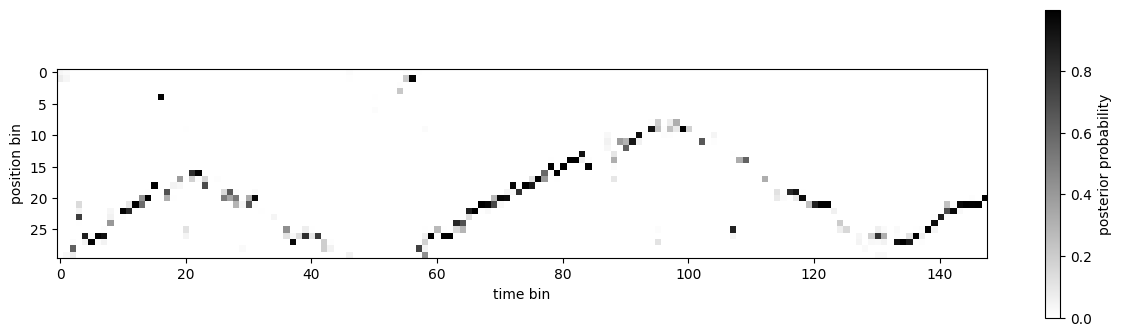

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(15,4))
img = ax.imshow(posteriors[2][:,:,0].T, cmap="gray_r")
ax.set(ylabel="position bin", xlabel="time bin")
plt.colorbar(img, label="posterior probability");

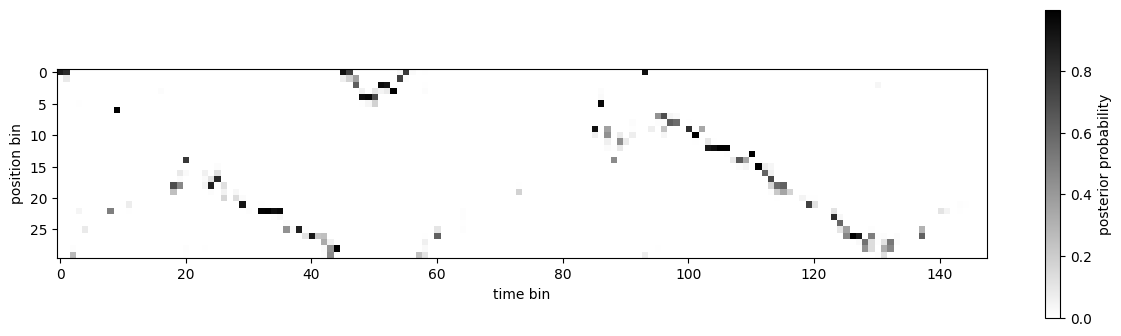

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(15,4))
img = ax.imshow(posteriors[2][:,:,1].T, cmap="gray_r")
ax.set(ylabel="position bin", xlabel="time bin")
plt.colorbar(img, label="posterior probability");

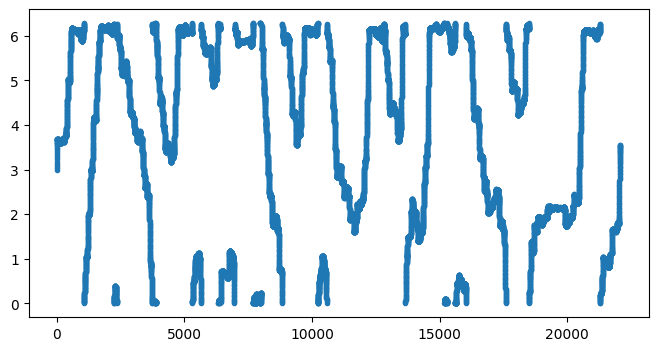

In [164]:
seg = 0
start = segemnts[0][0]
end = segemnts[-1][1]
ind = np.where((stimulus['stimulus']['timestamp']>start) & (stimulus['stimulus']['timestamp']<end))[0]
pos0 = stimulus['stimulus']['linearpos'][ind]
plt.figure(figsize=(8,4))
plt.plot(pos0, '.')

In [48]:
decode_segments.center

array([6241.7091, 6241.9091, 6244.3758, 6244.5758, 6244.7758, 6244.9758,
       6245.1758, 6245.3758, 6245.5758, 6252.8423, 6253.0423, 6253.2423,
       6253.4423, 6253.6423, 6262.3089, 6262.5089, 6262.7089, 6262.9089,
       6263.1089, 6263.3089, 6263.5089, 6263.7089, 6263.9089, 6264.1089,
       6268.0421, 6268.2421, 6268.4421, 6268.6421, 6268.8421, 6269.0421,
       6269.2421, 6269.4421, 6269.6421, 6269.8421, 6270.0421, 6270.2421,
       6270.4421, 6270.6421, 6270.8421, 6271.0421, 6271.2421, 6274.242 ,
       6274.442 , 6274.642 , 6274.842 , 6275.042 , 6292.2418, 6315.0415,
       6315.2415, 6315.4415, 6326.6414, 6326.8414, 6332.8746, 6333.0746,
       6333.2746, 6333.4746, 6333.6746, 6333.8746, 6334.0746, 6334.2746,
       6334.4746, 6334.6746, 6334.8746, 6335.0746, 6335.2746, 6335.4746,
       6335.6746, 6335.8746, 6336.0746, 6336.2746, 6336.4746, 6336.6746,
       6337.6412, 6337.8412, 6338.0412, 6338.2412, 6338.4412, 6338.6412,
       6338.8412, 6339.0412, 6339.2412, 6360.6743, 

In [55]:
np.argmax(posteriors[4][:,:,0], axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

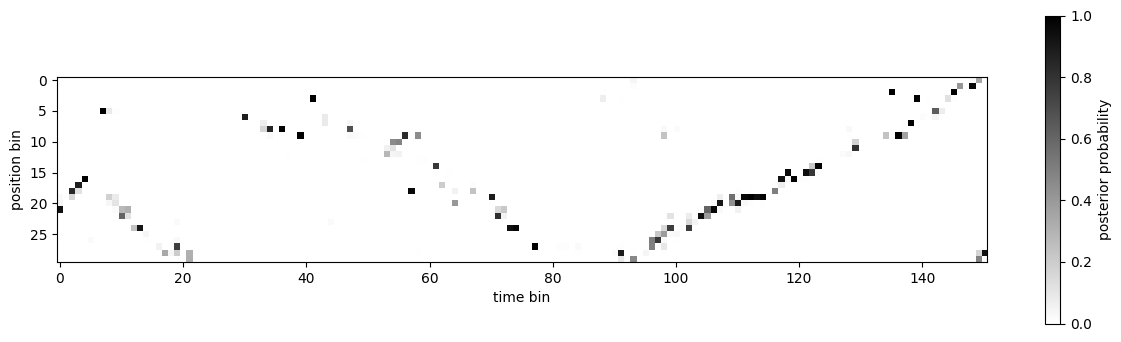

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(15,4))
img = ax.imshow(posteriors[3][:,:,0].T, cmap="gray_r")
ax.set(ylabel="position bin", xlabel="time bin")
plt.colorbar(img, label="posterior probability");

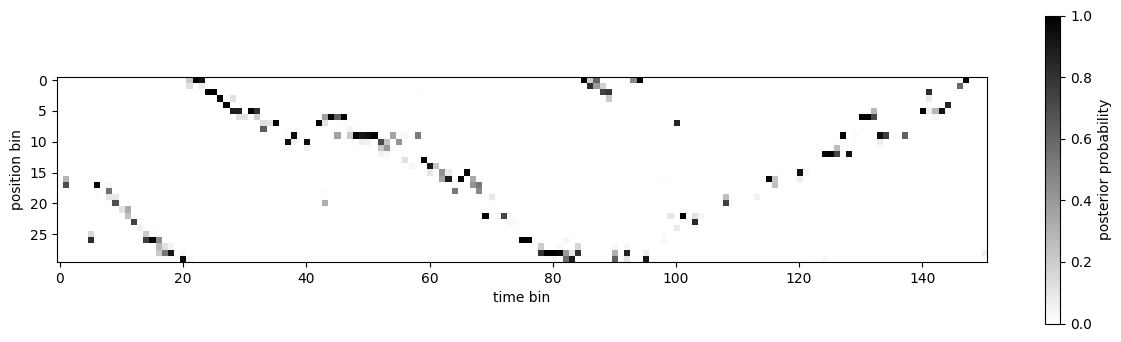

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(15,4))
img = ax.imshow(posteriors[3][:,:,1].T, cmap="gray_r")
ax.set(ylabel="position bin", xlabel="time bin")
plt.colorbar(img, label="posterior probability");